<a href="https://colab.research.google.com/github/kellykhy/DL2022-1/blob/main/effi0_0_88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -U git+https://github.com/albu/albumentations --no-cache-dir
! pip install tensorflow_addons
! pip uninstall opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-9o58iq69
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-9o58iq69
     |████████████████████████████████| 48.3 MB 1.3 MB/s 
  Created wheel for albumentations: filename=albumentations-1.2.0-py3-none-any.whl size=113474 sha256=c77559be18a2d8ac550e81fa7ca8a8571ddb09ff71ce4bcb6185a3e55e57223e
  Stored in directory: /tmp/pip-ephem-wheel-cache-84rn6xhn/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 11.9 

In [ ]:
! pip install opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.1 MB 38 kB/s 


In [ ]:
# 런타임 재시작

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dpath = '/content/drive/MyDrive/'

In [ ]:
! unzip -qq /content/drive/MyDrive/unifesp-x-ray-body-part-classifier.zip

In [ ]:
import os
os.listdir()

['.config',
 'test',
 'sample_submission.csv',
 'train',
 'drive',
 'train.csv',
 'sample_data']

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import albumentations as album
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.model_selection import StratifiedKFold

In [ ]:
N_SPLITS = 4
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
EPOCHS = 200    
PATIENCE = 8
MAX_LR = 1e-5
MIN_LR = 1e-6

In [ ]:
class_names = np.array(["Abdomen", "Ankle", "Cervical Spine", "Chest", 
                        "Clavicles", "Elbow", "Feet", "Finger",
                        "Forearm", "Hand", "Hip", "Knee",  
                        "Lower Leg", "Lumbar Spine", "Others", "Pelvis", 
                        "Shoulder", "Sinus", "Skull", "Thigh", 
                        "Thoracic Spine", "Wrist"])

In [ ]:
df = pd.read_csv(dpath+"train.csv")
df.head()

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,15
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,12
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,14
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,3


In [ ]:
images_path = "/content/train/"
temp_SOPInstanceUID = []
for i in df.SOPInstanceUID:
    temp_SOPInstanceUID.append(images_path + i + ".png")
df.SOPInstanceUID = temp_SOPInstanceUID

In [ ]:
num_classes = 22
targets = np.zeros((len(df.Target), num_classes), dtype=int)
for i, t in enumerate(df.Target):
    target = t.strip().split()
    for j in target:
        targets[i, int(j)] = 1

In [ ]:
df2 = pd.DataFrame(targets, columns=class_names)
df = pd.concat([df, df2], axis=1) 
df.head()

,SOPInstanceUID,Target,Abdomen,Ankle,Cervical Spine,Chest,Clavicles,Elbow,Feet,Finger,...,Lower Leg,Lumbar Spine,Others,Pelvis,Shoulder,Sinus,Skull,Thigh,Thoracic Spine,Wrist
0,/content/train/1.2.826.0.1.3680043.8.498.10025...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,/content/train/1.2.826.0.1.3680043.8.498.10036...,15,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,/content/train/1.2.826.0.1.3680043.8.498.10038...,12,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,/content/train/1.2.826.0.1.3680043.8.498.10050...,14,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,/content/train/1.2.826.0.1.3680043.8.498.10053...,3,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


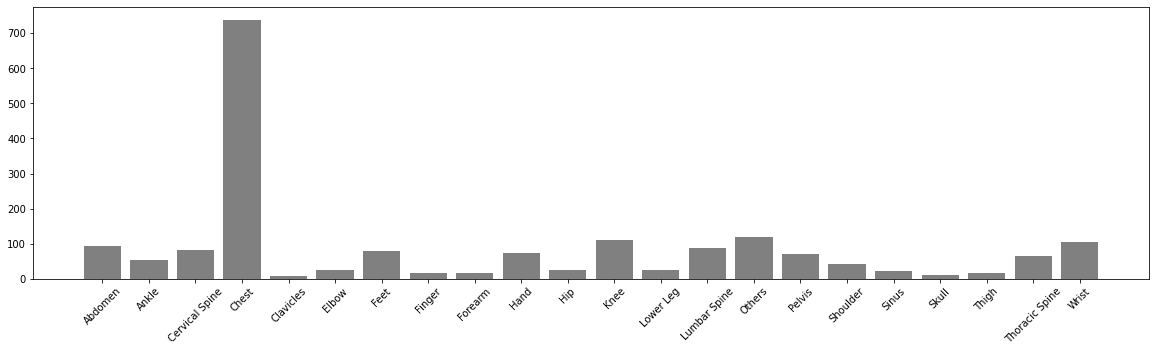

In [ ]:
plt.figure(figsize=(20, 5))
plt.bar(np.arange(22), targets.sum(axis=0), color='grey')
plt.xticks(ticks=np.arange(22), labels=class_names, rotation=45)
plt.show()

In [ ]:
print(targets.sum(axis=0)[4])

9


In [ ]:
print(targets.sum(axis=0)[-4])

10


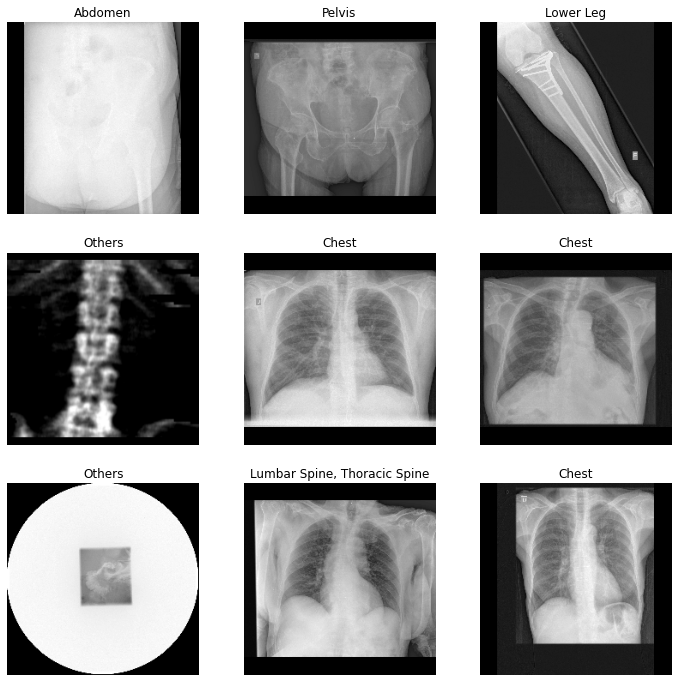

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(9):
    # image
    ax = plt.subplot(3, 3, i+1)
    filename = df.iloc[i].SOPInstanceUID
    img = imread(filename)
    plt.imshow(img, cmap='gray')
    # titles
    labels = df.iloc[i].Target.strip().split()
    if len(labels) == 1:
        plt.title(class_names[int(labels[0])])
    else:
        titles = []
        for label in labels:
            titles.append(class_names[int(label)])
        plt.title(", ".join(titles))
    plt.axis("off")
plt.show()

In [ ]:
df_test = pd.read_csv(dpath+"sample_submission.csv")
df_test.head()

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10001001190452685542...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,1.2.826.0.1.3680043.8.498.10022667601042710442...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
2,1.2.826.0.1.3680043.8.498.10024395388921105474...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
3,1.2.826.0.1.3680043.8.498.10026689165626095651...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
4,1.2.826.0.1.3680043.8.498.10035936364561920980...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...


In [ ]:
images_path = "../content/test/"
temp_SOPInstanceUID = []
for i in df_test.SOPInstanceUID:
    temp_SOPInstanceUID.append(images_path + i + ".png")
df_test.SOPInstanceUID = temp_SOPInstanceUID

In [ ]:
df_test.head()

,SOPInstanceUID,Target
0,../content/test/1.2.826.0.1.3680043.8.498.1000...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,../content/test/1.2.826.0.1.3680043.8.498.1002...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
2,../content/test/1.2.826.0.1.3680043.8.498.1002...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
3,../content/test/1.2.826.0.1.3680043.8.498.1002...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
4,../content/test/1.2.826.0.1.3680043.8.498.1003...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...


In [ ]:
X_test = df_test.SOPInstanceUID.to_numpy()

In [ ]:
X_test[:5]

array(['../content/test/1.2.826.0.1.3680043.8.498.10001001190452685542754353271306894106.png',
       '../content/test/1.2.826.0.1.3680043.8.498.10022667601042710442884728915610557590.png',
       '../content/test/1.2.826.0.1.3680043.8.498.10024395388921105474336784272390605225.png',
       '../content/test/1.2.826.0.1.3680043.8.498.10026689165626095651568657562992631805.png',
       '../content/test/1.2.826.0.1.3680043.8.498.10035936364561920980924160549027696414.png'],
      dtype=object)

In [ ]:
X = df.SOPInstanceUID.to_numpy()
y = df.iloc[:, 2:].to_numpy()

In [ ]:
print(X[:5], y[:5])

['/content/train/1.2.826.0.1.3680043.8.498.10025629581362719970278200333618114258.png'
 '/content/train/1.2.826.0.1.3680043.8.498.10036150326276641158002573300029848125.png'
 '/content/train/1.2.826.0.1.3680043.8.498.10038426859954986240523417641213777162.png'
 '/content/train/1.2.826.0.1.3680043.8.498.10050991192143676483577217922037244257.png'
 '/content/train/1.2.826.0.1.3680043.8.498.10053309524595490852815579052225336016.png'] [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [ ]:
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

for train_index, valid_index in skf.split(X, np.argmax(y, axis=1)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

print(f"train size: {y_train.shape[0]}")
print(f"valid size: {y_valid.shape[0]}")

train size: 1304
valid size: 434


In [ ]:
print(X_train[:5])
print(X_valid[:5])

['/content/train/1.2.826.0.1.3680043.8.498.10025629581362719970278200333618114258.png'
 '/content/train/1.2.826.0.1.3680043.8.498.10050991192143676483577217922037244257.png'
 '/content/train/1.2.826.0.1.3680043.8.498.10053309524595490852815579052225336016.png'
 '/content/train/1.2.826.0.1.3680043.8.498.10053755320637729867508668285241208441.png'
 '/content/train/1.2.826.0.1.3680043.8.498.10062189329714053601496804394945741428.png']
['/content/train/1.2.826.0.1.3680043.8.498.10036150326276641158002573300029848125.png'
 '/content/train/1.2.826.0.1.3680043.8.498.10038426859954986240523417641213777162.png'
 '/content/train/1.2.826.0.1.3680043.8.498.10092177056782233773275902757764299181.png'
 '/content/train/1.2.826.0.1.3680043.8.498.10093718510761734264315711288650185574.png'
 '/content/train/1.2.826.0.1.3680043.8.498.10105498531842222086756322461334605745.png']


In [ ]:
class DataAugmentation:
    def __init__(self):
        self.transforms = album.Compose([
            album.HorizontalFlip(p=0.5), #좌우반전
            album.VerticalFlip(p=0.5), #상하반전
            album.ShiftScaleRotate(shift_limit=0.15, 
                                   scale_limit=0.2, 
                                   rotate_limit=25, 
                                   border_mode=cv2.BORDER_CONSTANT, p=0.75),
            album.OneOf([
                album.RandomBrightnessContrast(brightness_limit=0.5, 
                                               contrast_limit=0.2, p=0.5),
                album.RandomGamma(gamma_limit=(70, 130), p=0.5),
                ], p=0.5),
            album.OneOf([
                album.Blur(p=0.1),
                album.GaussianBlur(p=0.1),
                album.MotionBlur(p=0.1),
                ], p=0.1),
            album.OneOf([
                album.GaussNoise(p=0.1),
                album.GridDropout(ratio=0.5, p=0.2),
                album.CoarseDropout(max_holes=16, max_height=16, max_width=16,
                                    min_holes= 8, min_height= 8, min_width= 8, p=0.2)
                ], p=0.5),
            ])

    def aug_fn(self, image):
        data = {"image":image}
        aug_data = self.transforms(**data)
        aug_img = aug_data["image"]
        aug_img = tf.cast(aug_img, tf.float32)
        return aug_img

    def augment_iamge(self, img, label):
        aug_img = tf.numpy_function(func=self.aug_fn, inp=[img], Tout=tf.float32)
        return aug_img, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def process_path(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=1, dtype=tf.uint8)
    return img, label

def process_test_path(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=1, dtype=tf.uint8)
    return img

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_ds = tf.data.Dataset.from_tensor_slices((X_test))

In [ ]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_test_path, num_parallel_calls=AUTOTUNE)

In [ ]:
aug_train = DataAugmentation()
train_ds = train_ds.map(aug_train.augment_iamge, num_parallel_calls=AUTOTUNE)

In [ ]:
train_ds = train_ds.batch(BATCH_SIZE)
valid_ds = valid_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
image_batch, label_batch = next(iter(train_ds))

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE).repeat()
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE).repeat()
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=(224, 224, 3),
                                                                   include_top=False, weights='imagenet')

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

In [ ]:
#for layer in base_model.layers[:13]:
    #layer.trainable = False # freeze first 13 layers

IndentationError: ignored

In [ ]:
#for layer in base_model.layers:
   # print(layer, layer.trainable)

In [ ]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

def get_model(input_shape, output_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.tile(inputs, (1, 1, 1, 3))

    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    outputs = tf.keras.layers.Dense(output_shape, activation='sigmoid', dtype='float32')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
model = get_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), output_shape=num_classes)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 tf.tile_1 (TFOpLambda)      (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 22)                28182     
                                                                 
Total params: 4,077,753
Trainable params: 4,035,730
Non-trainable params: 42,023
____________________________________________

In [ ]:
steps_per_epoch = len(y_train)//BATCH_SIZE
validation_steps = len(y_valid)//BATCH_SIZE

In [ ]:
model.compile(optimizer=tfa.optimizers.RectifiedAdam(learning_rate=MAX_LR,
                                                     total_steps=EPOCHS*steps_per_epoch,
                                                     warmup_proportion=0.1,
                                                     min_lr=MIN_LR), 
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['binary_accuracy'])

In [ ]:
my_callbacks = tf.keras.callbacks.EarlyStopping(patience=PATIENCE, 
                                                monitor='val_loss', 
                                                restore_best_weights=True)

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
history = model.fit(train_ds, 
                    validation_data=valid_ds,
                    epochs=EPOCHS,
                    callbacks=[my_callbacks],
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1,
                    )

Epoch 1/200
81/81 [==============================] - 52s 616ms/step - loss: 0.6865 - binary_accuracy: 0.5478 - val_loss: 0.7076 - val_binary_accuracy: 0.5246
Epoch 2/200
81/81 [==============================] - 51s 624ms/step - loss: 0.6851 - binary_accuracy: 0.5499 - val_loss: 0.6971 - val_binary_accuracy: 0.5362
Epoch 3/200
81/81 [==============================] - 52s 637ms/step - loss: 0.6828 - binary_accuracy: 0.5551 - val_loss: 0.6890 - val_binary_accuracy: 0.5478
Epoch 4/200
81/81 [==============================] - 52s 639ms/step - loss: 0.6781 - binary_accuracy: 0.5658 - val_loss: 0.6832 - val_binary_accuracy: 0.5571
Epoch 5/200
81/81 [==============================] - 55s 686ms/step - loss: 0.6720 - binary_accuracy: 0.5765 - val_loss: 0.6774 - val_binary_accuracy: 0.5662
Epoch 6/200
81/81 [==============================] - 50s 616ms/step - loss: 0.6632 - binary_accuracy: 0.5942 - val_loss: 0.6675 - val_binary_accuracy: 0.5888
Epoch 7/200
81/81 [==============================] -

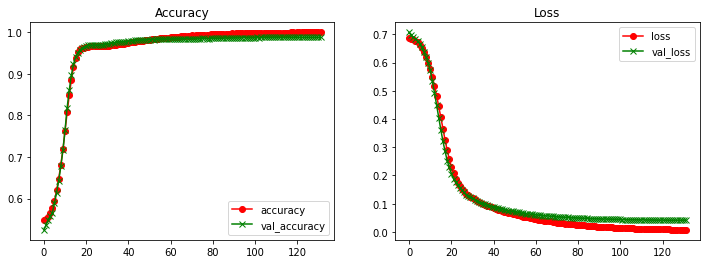

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.set_title('Accuracy')
ax1.plot(history.history['binary_accuracy'], 'r', marker="o", label='accuracy')
ax1.plot(history.history['val_binary_accuracy'], 'g', marker="x", label='val_accuracy')
ax1.legend()

ax2.set_title('Loss')
ax2.plot(history.history['loss'], 'r', marker="o", label='loss')
ax2.plot(history.history['val_loss'], 'g', marker="x", label='val_loss')
ax2.legend()

plt.show()

In [ ]:
pred = model.predict(test_ds, verbose=1)

temp = []
for i in pred:
    ans = np.where(i>0.9)[0]
    if ans.shape[0] == 0:
        temp.append(str(np.argmax(i)))
    else:
        temp.append(" ".join(ans.astype(str)))

df_test = pd.read_csv(dpath+"sample_submission.csv")
df_test.Target = temp

df_test.to_csv("./effi0.csv", index=False)

47/47 [==============================] - 8s 160ms/step


In [ ]:
df_test

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10001001190452685542...,9 21
1,1.2.826.0.1.3680043.8.498.10022667601042710442...,3
2,1.2.826.0.1.3680043.8.498.10024395388921105474...,21
3,1.2.826.0.1.3680043.8.498.10026689165626095651...,3
4,1.2.826.0.1.3680043.8.498.10035936364561920980...,3
...,...,...
738,1.2.826.0.1.3680043.8.498.98950979295424909746...,3
739,1.2.826.0.1.3680043.8.498.99120415799121180043...,3
740,1.2.826.0.1.3680043.8.498.99132008951330408682...,3
741,1.2.826.0.1.3680043.8.498.99611256581875030709...,21
